# # Code for plotting transmittance versus data frames, and using that to compute average of sections of interest.

Ratchawit Janewithayapun 

May 2025

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tkinter as tk
from tkinter import filedialog
import time
import os

# #Read master h5 data
Plot transmittance versus data frames.
Reads the intensity from h5 file, requires that the keys are correct, which may change depending on beamline processing pipeline version. This is based on CoSAXS June 2023.

Code for opening h5 adapted from CoSAXS Python data pipeline.

In [1]:
import h5py
import tkinter as tk
from tkinter import filedialog
import time

def read_master_file():
    # Create a pop-up window to select a file
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    # Bring the window to the front
    root.lift()
    root.attributes('-topmost', True)
    root.after_idle(lambda: root.attributes('-topmost', False))

    file_path = filedialog.askopenfilename(title="Select h5 File", filetypes=[("h5", "*.h5"), ("All files", "*.*")])

    # Define keys to extract from the HDF5 file
    keys = [
        ('i_0', '/entry/measurement/i_0'),
        ('i_t', '/entry/measurement/i_t'),
        ('dt', '/entry/instrument/eiger_2d/count_time'),
        ('sample', '/entry/instrument/pre_scan_snapshot/sample_description'),
        ('sample_type', '/entry/instrument/pre_scan_snapshot/sample_type')
    ]
    data = {}
    success, tries = False, 0

    # Retry opening the file for 5 seconds
    while not success and tries < 10:
        try:
            with h5py.File(file_path, 'r') as fh:
                for name, key in keys:
                    data[name] = fh[key][()]
            success = True
        except OSError as error:
            tries += 1
            time.sleep(0.5)

    if not success:
        raise RuntimeError(f'Could not open master file: {file_path}')
    
    return data


In [2]:
# read master file
data = read_master_file()

# copy config from cosaxs jupyter 

config ={'dark_i0': -4.1377008005e-07,
	 'dark_it': -1.7625337060000001e-06,
	 'empty_i0': 2.8145703245000003e-05,
	 'empty_it': 0.00013042940320000002,
	 'qSumStart': 0.01,
	 'qSumEnd': 0.08,
	 'absolute_scaling_saxs': 0.40429926868017735,
	 'absolute_scaling_waxs': 1.0,
	 'normalization': 'transmittance',
	 'average': False,
	 'pictures': 'None',
	 'cormap': False,
	 'auto_buffer': False,
	 'waxs': True,
	 'save': True,
	 'format': 'dat'}

In [ ]:
def normalize(data, config):
    normalization = config['normalization']
    if normalization == 'transmittance':
        empty = (config['empty_it'] - config['dark_it']) / (config['empty_i0'] - config['dark_i0'])
        norm = ( (data['i_t'] - config['dark_it']) / (data['i_0'] - config['dark_i0']) ) * (data['dt'] / empty )

    elif normalization == 'transmission':
        norm = (data['i_t'] - config['dark_it']) * data['dt']
    elif normalization == 'none':
        norm = np.ones(len(data['i_t']))
    else:
        raise RuntimeError(f'Unkown normalization: {normalization}. Allowed values are transmission, transmittance or none')
    return norm


Text(0, 0.5, 'transmittance')

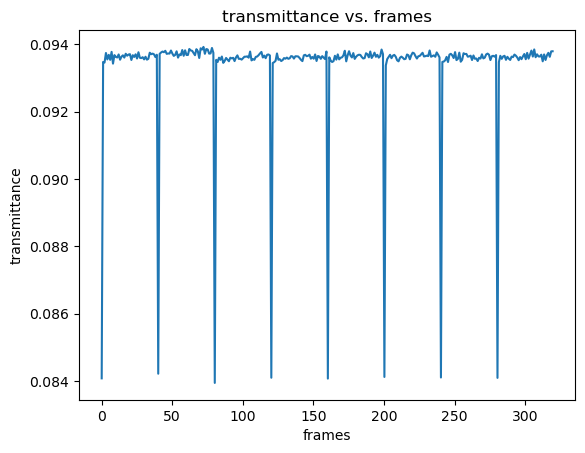

In [4]:
import numpy as np
import matplotlib.pyplot as plt


norm = normalize(data, config)

frames = np.linspace(0, 800,800)

plt.figure()
plt.plot(frames,norm)
plt.title('transmittance vs. frames')
plt.xlabel('frames')
plt.ylabel('transmittance')

# #Compute average of frames and plot

Specify the range of each section to be averaged using the tuples in shots.

In [7]:
def save (config, r1, r2, q_values, intensity_values, propagated_err):
    # Save the mean intensity and propagated error to a file
    import os

    # Ensure the directory exists
    os.makedirs(f'{config}_mean', exist_ok=True)
    try:
        np.savetxt(
            f'{config}_mean/mean_{r1:04d}_{r2:04d}.dat',
            np.column_stack((q_values, intensity_values, propagated_err)),
            header="q intensity propagated_error"
        )
        print(f"Averaged intensity and propagated errors computed for shots {r1:04d} to {r2:04d}")
    except Exception as e:
        print(f"Error saving file for shots {r1:04d} to {r2:04d}: {e}")

In [8]:
import numpy as np

# Define the shot ranges
shots = [(1, 39), (41, 79), (81, 119), (121, 159), (161, 199), (201, 239), (241, 279), (281, 319)]
config = 'pilatus'

# Loop through each range of shots
for r1, r2 in shots:
    num = np.linspace(r1, r2, (r2 - r1 + 1), dtype=int)
    
    # Initialize variables to compute the mean
    sum_data = None
    sum_errors = None
    count = 0
    
    for i in num:
        # Load the current shot data with zero-padded ID
        data = np.loadtxt(f'{config}/shot_{i:04d}_{config}.dat')
        
        # Accumulate the sum of intensities
        if sum_data is None:
            sum_data = data[:, 1]  # Initialize with the first shot's intensity
            sum_errors = data[:, 2]**2  # Initialize with the first shot's error
        else:
            sum_data += data[:, 1]
            sum_errors += data[:, 2]**2
        
        count += 1
    
    
    # get q-values
    q_values = data[:, 0]
    # Compute the mean intensity
    mean_intensity = sum_data / count
      # Compute the propagated error
    propagated_error = np.sqrt(sum_errors) / count
    
    # Save the mean intensity and propagated error to a file
    save(config, r1, r2, q_values, mean_intensity, propagated_error)

Averaged intensity and propagated errors computed for shots 0001 to 0039
Averaged intensity and propagated errors computed for shots 0041 to 0079
Averaged intensity and propagated errors computed for shots 0081 to 0119
Averaged intensity and propagated errors computed for shots 0121 to 0159
Averaged intensity and propagated errors computed for shots 0161 to 0199
Averaged intensity and propagated errors computed for shots 0201 to 0239
Averaged intensity and propagated errors computed for shots 0241 to 0279
Averaged intensity and propagated errors computed for shots 0281 to 0319


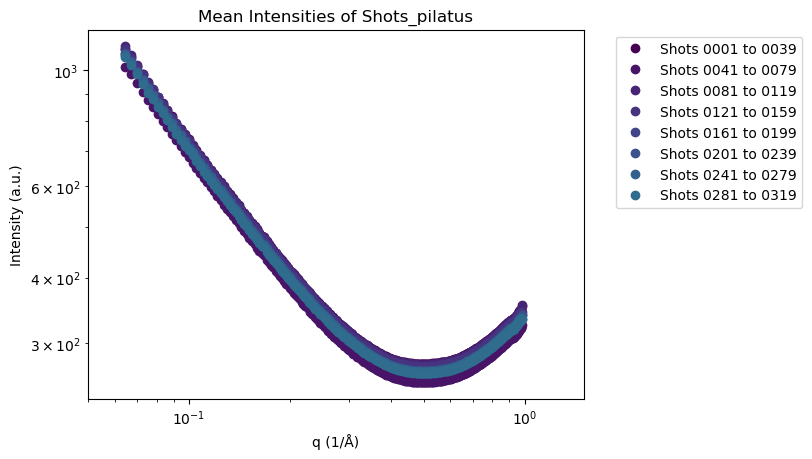

In [10]:
# Define the shot ranges
shots = [(1, 39), (41, 79), (81, 119), (121, 159), (161, 199), (201, 239), (241, 279), (281, 319)]
config = 'pilatus'

plt.figure()
cmap = plt.get_cmap('viridis')
for r1, r2 in shots:
    
    data = np.loadtxt(f'{config}_mean/mean_{r1:04d}_{r2:04d}.dat')
    q_values = data[:, 0]
    intensity_values = data[:, 1]

    plt.plot(q_values, intensity_values, 'o', color=cmap(r1 / 800), label=f'Shots {r1:04d} to {r2:04d}')

plt.xscale('log')
plt.xlim(0.05, 1.5)
plt.yscale('log')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('q (1/Å)')
plt.title(f'Mean Intensities of Shots_{config}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [11]:
import numpy as np

# Define the shot ranges
shots = [(1, 39), (41, 79), (81, 119), (121, 159), (161, 199), (201, 239), (241, 279), (281, 319)]
config = 'eiger'

# Loop through each range of shots
for r1, r2 in shots:
    num = np.linspace(r1, r2, (r2 - r1 + 1), dtype=int)
    
    # Initialize variables to compute the mean
    sum_data = None
    sum_errors = None
    count = 0
    
    for i in num:
        # Load the current shot data with zero-padded ID
        data = np.loadtxt(f'{config}/shot_{i:04d}_{config}.dat')
        
        # Accumulate the sum of intensities
        if sum_data is None:
            sum_data = data[:, 1]  # Initialize with the first shot's intensity
            sum_errors = data[:, 2]**2  # Initialize with the first shot's error
        else:
            sum_data += data[:, 1]
            sum_errors += data[:, 2]**2
        
        count += 1
    
    
    # get q-values
    q_values = data[:, 0]
    # Compute the mean intensity
    mean_intensity = sum_data / count
      # Compute the propagated error
    propagated_error = np.sqrt(sum_errors) / count
    
    # Save the mean intensity and propagated error to a file
    save(config, r1, r2, q_values, mean_intensity, propagated_error)

Averaged intensity and propagated errors computed for shots 0001 to 0039
Averaged intensity and propagated errors computed for shots 0041 to 0079
Averaged intensity and propagated errors computed for shots 0081 to 0119
Averaged intensity and propagated errors computed for shots 0121 to 0159
Averaged intensity and propagated errors computed for shots 0161 to 0199
Averaged intensity and propagated errors computed for shots 0201 to 0239
Averaged intensity and propagated errors computed for shots 0241 to 0279
Averaged intensity and propagated errors computed for shots 0281 to 0319


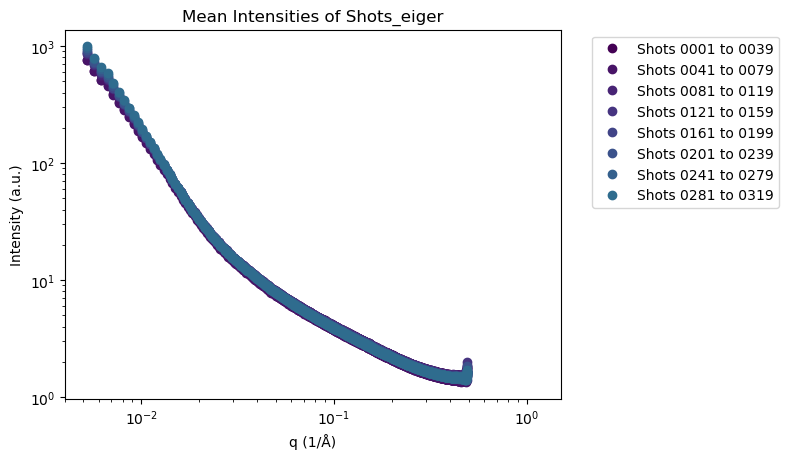

In [14]:
# Define the shot ranges
shots = [(1, 39), (41, 79), (81, 119), (121, 159), (161, 199), (201, 239), (241, 279), (281, 319)]
config = 'eiger'

plt.figure()
cmap = plt.get_cmap('viridis')
for r1, r2 in shots:
    
    data = np.loadtxt(f'{config}_mean/mean_{r1:04d}_{r2:04d}.dat')
    q_values = data[:, 0]
    intensity_values = data[:, 1]

    plt.plot(q_values, intensity_values, 'o', color=cmap(r1 / 800), label=f'Shots {r1:04d} to {r2:04d}')

plt.xscale('log')
plt.xlim(0.004, 1.5)
plt.yscale('log')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('q (1/Å)')
plt.title(f'Mean Intensities of Shots_{config}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')